In [346]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


device = torch.device("cuda")
image_path = './data/mnist/train'
batch_size = 64
z_size = 100
image_size = (28, 28)
n_filters = 32 

In [347]:

import torch
import numpy as np
import torchvision 
from torchvision import transforms 
from torch.utils.data import DataLoader



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=False)


# torch.manual_seed(1)
# np.random.seed(1)

## Set up the dataset

mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, 
                      shuffle=True, drop_last=True, num_workers=20)



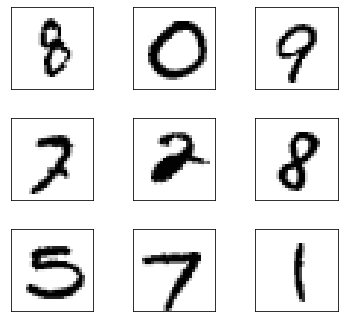

In [348]:
#show some images
from utils_gen import plot_images
plot_images(mnist_dl)

In [349]:
from generators import Generator, Discriminator
gen_model = Generator().to(device)
disc_model = Discriminator().to(device)

In [350]:


## Loss function and optimizers:
loss_fn = nn.BCEWithLogitsLoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)



In [351]:


def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1 
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

def sample_from_latent(n_samples, z_size=100, mode_z='normal'):
    return create_noise(n_samples, z_size, 'normal')

In [359]:

from tqdm.auto import tqdm
from torch.nn import BCEWithLogitsLoss

bce = BCEWithLogitsLoss()
def compute_loss(pred, target):
    return bce(pred, target)
      
 
class Trainner():
    def __init__(self, generator, discriminator, train_loader, device):
        self.generator = generator
        self.discriminator = discriminator
        self.device = device
        self.losses = []
        self.losses_gen = []
        self.train_loader = train_loader

        self.discriminator.to(self.device)
        self.generator.to(self.device)

        self.optimizer_G = torch.optim.AdamW(self.generator.parameters(), lr=0.0003)
        self.optimizer_D = torch.optim.AdamW(self.discriminator.parameters(), lr=0.0002)

    def discriminator_step(self, img_batch, labels_batch):
        batch_size = img_batch.shape[0]
        img_batch = img_batch.to(self.device)
        ones = torch.ones((batch_size, 1)).to(self.device)
        zeros = torch.zeros((batch_size, 1)).to(self.device)
        z_input = sample_from_latent(batch_size, 100).to(self.device)

        fake_imgs = self.generator(z_input)

        y_pred = self.discriminator(img_batch)
        y_pred_fake = self.discriminator(fake_imgs)

        loss = compute_loss(y_pred, ones)
        loss += compute_loss(y_pred_fake, zeros)

        self.optimizer_D.zero_grad()
        loss.backward()
        self.optimizer_D.step()        

        return loss.cpu().item()

    def generator_step(self, labels_batch, img_batch):
        self.optimizer_G.zero_grad()

        ones = torch.ones((labels_batch.shape[0], 1)).to(self.device)
        z_input = sample_from_latent(img_batch.shape[0]).to(self.device)

        fake_imgs = self.generator(z_input)
        y_pred_fake = self.discriminator(fake_imgs)
        loss = compute_loss(y_pred_fake, ones)
        loss.backward()

        self.optimizer_G.step()
        return loss.cpu().item()    


    def train_both(self, epochs = 1, train_gen_every = 1, train_dis_every = 1):
        progress_bar = tqdm(range(epochs*len(self.train_loader)))
        self.discriminator.train()
        self.generator.train()
        for epoch in range(epochs):
            for iter, (img_batch, labels_batch) in enumerate(self.train_loader):
                if iter % train_dis_every == 0:
                    d_loss = self.discriminator_step(img_batch, labels_batch)
                if iter % train_gen_every == 0:
                    g_loss = self.generator_step(labels_batch, img_batch)

                progress_bar.update(1)
                if d_loss:
                    self.losses.append(d_loss)
                if g_loss:
                    self.losses_gen.append(g_loss)
            print("Epoch: {} - D loss: {} - G loss: {}".format(epoch, d_loss, g_loss))        
                


In [353]:
## Train the discriminator
def d_train(img_batch):
    batch_size = img_batch.shape[0]
    img_batch = img_batch.to(device)
    ones = torch.ones((batch_size, 1), device=device)
    zeros = torch.zeros((batch_size, 1), device=device)
    z_input = sample_from_latent(batch_size, 100).to(device)

    fake_imgs = gen_model(z_input)
    
    d_proba_real = disc_model(img_batch)
    d_proba_fake = disc_model(fake_imgs)
    
    d_loss_real = compute_loss(d_proba_real, ones)
    d_loss_fake = compute_loss(d_proba_fake, zeros)
    d_loss = d_loss_real + d_loss_fake
    
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()



In [354]:
## Train the generator
def g_train(img_batch):
    g_optimizer.zero_grad()
    batch_size = img_batch.size(0)
    input_z = sample_from_latent(batch_size, z_size).to(device)
    ones = torch.ones((batch_size, 1 ), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = compute_loss(d_proba_fake, ones)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()

In [335]:
from tqdm.auto import tqdm
mode_z = 'uniform'
fixed_z = sample_from_latent(batch_size, z_size, mode_z).to(device)
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

epoch_samples = []

num_epochs = 50
# torch.manual_seed(1)

progress_bar = tqdm(range(num_epochs*len(mnist_dl)))
for epoch in range(1, num_epochs+1):    
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        progress_bar.update(1)
 
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

  0%|          | 0/46850 [00:00<?, ?it/s]

Epoch 001 | Avg Losses >> G/D 4.9574/0.0976
Epoch 002 | Avg Losses >> G/D 4.6320/0.1501
Epoch 003 | Avg Losses >> G/D 3.8072/0.2600
Epoch 004 | Avg Losses >> G/D 3.0570/0.3399
Epoch 005 | Avg Losses >> G/D 2.8537/0.3426
Epoch 006 | Avg Losses >> G/D 2.8768/0.3340
Epoch 007 | Avg Losses >> G/D 2.8844/0.3414
Epoch 008 | Avg Losses >> G/D 2.8917/0.3352
Epoch 009 | Avg Losses >> G/D 2.9302/0.3531
Epoch 010 | Avg Losses >> G/D 2.8823/0.3198
Epoch 011 | Avg Losses >> G/D 2.9723/0.3037
Epoch 012 | Avg Losses >> G/D 2.9875/0.3051
Epoch 013 | Avg Losses >> G/D 3.0442/0.2931
Epoch 014 | Avg Losses >> G/D 3.0862/0.2902
Epoch 015 | Avg Losses >> G/D 3.2372/0.2600
Epoch 016 | Avg Losses >> G/D 3.2535/0.2739
Epoch 017 | Avg Losses >> G/D 3.1742/0.2691
Epoch 018 | Avg Losses >> G/D 3.2978/0.2566
Epoch 019 | Avg Losses >> G/D 3.2816/0.2560
Epoch 020 | Avg Losses >> G/D 3.3795/0.2427
Epoch 021 | Avg Losses >> G/D 3.4394/0.2411
Epoch 022 | Avg Losses >> G/D 3.3596/0.2674
Epoch 023 | Avg Losses >> G/D 3.

In [360]:
trainer = Trainner(Generator(), Discriminator(), mnist_dl, device)
trainer.train_both(epochs=50, train_gen_every=1, train_dis_every=1)

  0%|          | 0/46850 [00:00<?, ?it/s]

Epoch: 0 - D loss: 0.09979847818613052 - G loss: 6.023756980895996
Epoch: 1 - D loss: 0.2306576371192932 - G loss: 2.6397573947906494
Epoch: 2 - D loss: 0.39296019077301025 - G loss: 5.125332832336426
Epoch: 3 - D loss: 0.3482854664325714 - G loss: 4.343288421630859
Epoch: 4 - D loss: 0.7077177166938782 - G loss: 3.551884412765503
Epoch: 5 - D loss: 0.28701290488243103 - G loss: 2.475121021270752
Epoch: 6 - D loss: 0.396168053150177 - G loss: 1.2085893154144287
Epoch: 7 - D loss: 0.17315402626991272 - G loss: 3.4474680423736572
Epoch: 8 - D loss: 0.6336185336112976 - G loss: 2.310993194580078
Epoch: 9 - D loss: 0.3815974295139313 - G loss: 2.8145205974578857
Epoch: 10 - D loss: 0.2400224506855011 - G loss: 2.0966758728027344
Epoch: 11 - D loss: 0.2037830501794815 - G loss: 1.6547534465789795
Epoch: 12 - D loss: 0.19520875811576843 - G loss: 2.380788803100586
Epoch: 13 - D loss: 0.20194344222545624 - G loss: 2.661776304244995
Epoch: 14 - D loss: 0.2670997977256775 - G loss: 2.7399206161

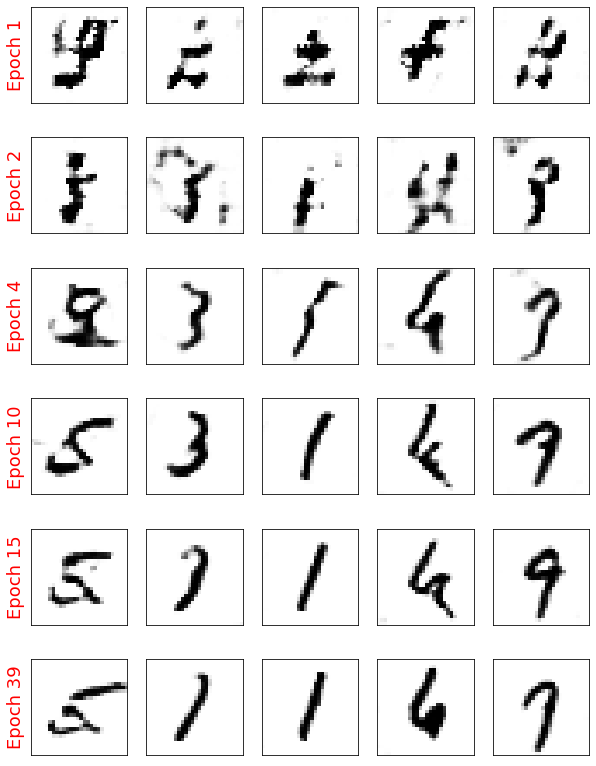

In [337]:
selected_epochs = [1, 2, 4, 10, 15, 39]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(len(selected_epochs), 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()

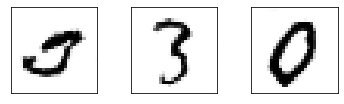

In [395]:

z_input = sample_from_latent(3).to(device)
fake_imgs = trainer.generator(z_input)
img0 = fake_imgs.detach().cpu().numpy()


#Show images
plt.figure(figsize=(5,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.tight_layout()
    plt.imshow(img0[i].reshape(28,28), cmap='binary', interpolation='none')
    plt.xticks([])
    plt.yticks([])